# Predicting MLB Player Performance. A Product of the Statcast Era.

### Trevor Flanagan

This Notebook contains the code used to explore MLB hitter data and see how accurately an ML model can predict next season WAR based off season stats.

## Background

The Statcast Era sparked in 2015 with all 30 major league ballparks adopting Statcast - a new tracking technology. The technology allowed for some advanced statistics to be recorded from games.Since it's existence it's presence has been feltm really breathing life into a competitive marketplace with baseball statisticians **influencing front office decisions, training & conditioning, in-game managerial decisions**.

With the more stat-focused age of MLB the game has been changing rapidly from what I knew growing up watching it:

* Teams are shifting their entire infields to cover one side of the field that the batter is likely to hit to
* It's no longer universally excepted that your best batter hit's 3rd
* Seemingly every team has one or more guy that can throw over 100mph

I will be looking to **predict MLB hitters WAR based off their previous season statsitics**.

Data for this project is sourced from a combination of FanGraphs, Baseball Reference, and Baseball Savant. This data is extracted with the help of the **pybaseball** package in python

In [1]:
#ignore Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

install pybaseball
#%pip install pybaseball

In [2]:
#import libraries

#Libraries to help reading in data
import os
import pandas as pd
import numpy as np
from pybaseball import batting_stats

#Libraries to help with model building and assessment
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from statistics import stdev
import seaborn as sns
import matplotlib.pyplot as plt

## Data Preparation

Data is extracted from pybaseball

The variables we will have to filter out are:
* Data pulled within the **last 20 seasons**
* Players need to have at least **200 plate appearances** for their season to count
* We're **excluding players with only 1 season** of data since they won't have a next season WAR to predict

Other cleaning steps:
* Team is coded as a string, in order to fit into a model it needs to be coded as a numeric variable "Team Code"
* The string variables "Dol" and "Age Rng" won't be useful for model building or analysis so they will both be dropped from the dataframe

In [3]:
#Define start and end years for our sample of data
START = 2002
END = 2022

#Pull data from pybaseall, with qual=200 to exclude seasons where the player had <200 plate appearences
batstat = batting_stats(START, END, qual=200)

#Exclude statistics with Null Values
null_values = batstat.isnull().sum()
batstat_nonnulls = batstat.columns[null_values == 0]
batstat = batstat[batstat_nonnulls]

#Code "Team" variable as numeric variable "Team Code"
batstat["Team Code"] = batstat['Team'].astype("category").cat.codes

#Drop Dol and Age Rng columns
batstat.drop(columns = ["Dol", "Age Rng"], inplace = True)


#Print table head
batstat.head()

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,Cent%+,Oppo%+,Soft%+,Med%+,Hard%+,Events,CStr%,CSW%,L-WAR,Team Code
0,1109,2002,Barry Bonds,SFG,37,143,403,612,149,70,...,106,87,64,83,171,0,0.127,0.191,12.7,28
1,1109,2004,Barry Bonds,SFG,39,147,373,617,135,60,...,96,86,65,76,171,0,0.124,0.164,11.9,28
8,15640,2022,Aaron Judge,NYY,30,157,570,696,177,87,...,91,84,46,83,159,404,0.169,0.287,11.2,22
15,13611,2018,Mookie Betts,BOS,25,136,520,614,180,96,...,102,73,69,92,125,434,0.220,0.270,10.4,5
2,1109,2003,Barry Bonds,SFG,38,130,390,550,133,65,...,116,71,93,78,161,0,0.135,0.223,10.2,28


## Creating our predictor variable
.
WAR (Wins Above Replacement) is highly regarded as the best existing metric for player analysis.

For hitters the equation to calculate WAR is:

WAR = (Batting Runs(RBI) + Fielding Runs Above Average + Positional Adjustment + League Adjustment + Base Running Runs) + Runs Added or Lost Due to Grounding into Double Players/Runs Per Win

Since the purpose of our project is to build a model that can predict future WAR we're going to be **creating a new variable in our dataset called Next_WAR** which is equal a players next season WAR. If it's the players last season, or the next season hasn't been played yet Next_WAR is NaN and will be dropped from the train/test data we'll use to build the model.

First, it will be helpful to have a baseline for what WAR looks like and how it's distributed

In [4]:
stdev(batstat["WAR"])

1.9323831867747412

<AxesSubplot:xlabel='WAR', ylabel='Density'>

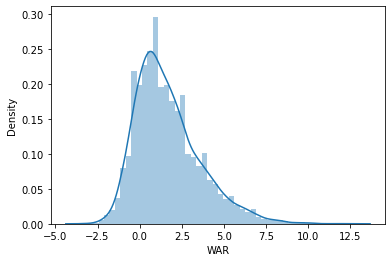

In [5]:
sns.distplot(batstat["WAR"])

Looking at this curve we can see it's slightly right tailed, but it's not far from normally distributed. This may come from the fact that players who excel remain in he league, while those who fall under the middle of the bell curve are being sent down to the minors. And remember, seasons where the player doesn't have 2 consecutive seasons with at last 200 plate appearances will not be recorded. so this gives us farily reasonable confidence that WAR it normally distributed wholistically.

When we're looking to assess effectiveness of our model in terms of RMSE, it will be a helpful baseline to know what one standard deviation is.

Now we can create the Next_WAR variable

In [6]:
#Define a function that will create the prediction variable for our models: Next_WAR
def next_season(player):
    player.sort_values("Season", inplace = True)
    player["Next_WAR"] = player["WAR"].shift(-1)
    player.sort_values("IDfg", inplace = True)
    return player

#Apply our new function to the batstat dataset
batstat = batstat.groupby("IDfg", group_keys=False).apply(next_season)

#Print out a table that shows we suceeded in accurately creating our Next_WAR variable
batstat[["IDfg", "Name", "Season", "WAR", "Next_WAR"]].head(12)

,IDfg,Name,Season,WAR,Next_WAR
5562,1,Alfredo Amezaga,2006,1.1,2.0
5006,1,Alfredo Amezaga,2007,2.0,1.2
5252,1,Alfredo Amezaga,2008,1.2,NaN
1169,2,Garret Anderson,2002,3.7,5.1
864,2,Garret Anderson,2003,5.1,0.8
2569,2,Garret Anderson,2004,0.8,-0.2
4187,2,Garret Anderson,2005,-0.2,0.1
3964,2,Garret Anderson,2006,0.1,1.4
1925,2,Garret Anderson,2007,1.4,1.4
3346,2,Garret Anderson,2008,1.4,-1.1


## Identify Predictors

We don't want our model to have 130 predictor variables for two main reasons
* That would cause some pretty long computing times
* The **Curse of Dimensionality** - as the number of dimensions increase the accompanying volume of the hyperspace explodes

So instead, we're going to fit our data to a Simple Linear model and use a **Sequential Feature Selector** from sklearn to perform forward selection of the **best 15 variables** for determining WAR

In [7]:
#The following code was run in Google Colab since my version of python 
#doesn't have the SequentialFeatureSelector from sklearn

#Identify numeric variables compatible with a linear model
#removed_columns = ["Next_WAR", "Name", "Team", "IDgf", "Season"]
#selected_columns = batstat.columns[~batstat.columns.isin(removed_columns)]


#Establish Simple Linear Regression as the baseline for our Sequential Feature Selection
#lr = LinearRegression()

#Time series split gaurentees new season data won't influence calculations for older predictions
#split = TimeSeriesSplit(n_splits=3) 

#Perform forward selection for top 15 features
#sfs = SequentialFeatureSelector(lr, n_features_to_select= 15, direction="forward", cv=split)
#sfs.fit(batstat[selected_columns], batstat["Next_WAR"])

#Pull list of predictors from sfs
#predictors = list(selected_columns[sfs.get_support()])
#predictors

In [8]:
#Predictor values are hard coded using the product of Google Colab
predictors = ['Age',
 'IBB',
 'SO',
 'SB',
 'BU',
 'BB%',
 'ISO',
 'BABIP',
 'WAR',
 'Spd',
 'PH',
 'CB%',
 'Pull%',
 'Soft%+',
 'Hard%+']

## Train Test Split
Preparing to build our model we'll have to:
1. first remove seasons where Next_WAR is NaN
2. Separate the data into training(75%) and test(25%) data

In [9]:
#Remove seasons where Next_WAR == NaN
batstat = batstat.dropna().copy()

# Define X and y variables
X = batstat[predictors]
y = batstat["Next_WAR"]

#Perform Train-Test-Split function
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 100)

## Build and Evaluate a First Simple Model

For our baseline model we'll use sklearn's LinearRegression


In [10]:
#Set Linear Regression model and fit it to our training data
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

LinearRegression()

Now we'll generate predictions for Next_WAR for our X_train data and compare it to the actual Next_WAR in the y_train data.

In [11]:
# Generate predictions using baseline_model and X_train
y_pred_baseline = baseline_model.predict(X_train)

# Evaluate using mean_squared_error with squared=False
baseline_rmse = mean_squared_error(y_train, y_pred_baseline, squared=False)
baseline_rmse

1.6489071991810345

Let's perform cross validation to see how the model performs on unseen data

In [13]:
# Import the relevant function
from sklearn.model_selection import cross_val_score

# Get the cross validated scores for our baseline model
baseline_cv = cross_val_score(baseline_model, X_train, y_train, scoring="neg_root_mean_squared_error")

# Display the average of the cross-validated scores
baseline_cv_rmse = -(baseline_cv.mean())
baseline_cv_rmse

1.658667284536147

## Analysis of Baseline Model

Our **RMSE is about 1.649**. So this means the simple linear regression model is on average off by about 1.65 WAR in it's prediction of a player's Next_WAR. If we remember that is **within 1 standard deviation of WAR** distribution we calculated for the whole dataset. That's pretty good already!

For the next iteration of the model we're going to try to add polynomial factors to make it greedier and generally less Underfit.

## Use PolynomialFeatures to Reduce Underfitting

The idea behind Polynomial features is that **not every stat in our model is likely to have a perfectly linear relationship with Next_WAR**. 

Take Age for example, which is in our model. One could expect that a player just entering the league is going to have to have some adjustment time to get used to the Major League level, and as they compete at that level for a few years they enter the peak of their career, a positive correlation between Age and Next_WAR. Once the same player passes his prime though, and continues to age you might expect you can start seeing a negative correlation between age and Next_WAR.

Adding polynomial degrees to our model make's it possible to **capture these non-linear complexities, at the risk of overfitting**

In [14]:
# Instantiate polynomial features transformer
poly = PolynomialFeatures()

# Fit transformer on entire X_train
poly.fit(X_train)

# Create transformed data matrix by transforming X_train
X_train_poly = poly.transform(X_train)

In [18]:
# Fit baseline_model
baseline_model.fit(X_train_poly, y_train)

# Make predictions
y_pred_poly = baseline_model.predict(X_train_poly)

# Find the RMSE on the full y_pred_poly and y_train
poly_rmse = mean_squared_error(y_train, y_pred_poly, squared=False)

#Perform Cross-Validation

# Get the cross validated scores for our transformed features
poly_cv = cross_val_score(baseline_model, X_train_poly, y_train, scoring="neg_root_mean_squared_error")

# Display the average of the cross-validated scores
poly_cv_rmse = -(poly_cv.mean())

In [19]:
print("Baseline Model")
print("Train RMSE:", baseline_rmse)
print("Validation RMSE:", baseline_cv_rmse)
print()
print("Model with Polynomial Transformation")
print("Train RMSE:", poly_rmse)
print("Validation RMSE:", poly_cv_rmse)

Baseline Model
Train RMSE: 1.6489071991810345
Validation RMSE: 1.658667284536147

Model with Polynomial Transformation
Train RMSE: 1.6092359897852409
Validation RMSE: 1.6943929205414754


Note: our RMSE decreased with our testing data on seen data. On the other hand, our unseen data has a higher RMSE with the cross validation.

While it's true that we are ultimately concerned with producing a model that performs best with blind data, this is fine becasue we're intentionally increasing overfitting at this stage with the hopes that in our third model we can reduce overfitting with with Regularization, while keeping the benefits from the polynomial factors addition to the model.

**So how do we decide how many degrees of polynomials to add?**

To find this we'll test our model at different polynomial degrees and see how differently they perform.

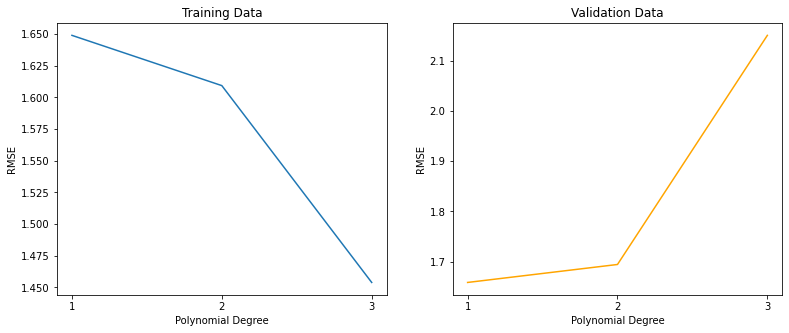

In [20]:
# Create lists of RMSE values
train_rmse = []
val_rmse = []

# Create list of degrees we want to consider
degrees = [*range(1,4)]

for degree in degrees:
    # Create transformer of relevant degree and transform X_train
    poly = PolynomialFeatures(degree)
    X_train_poly = poly.fit_transform(X_train)
    baseline_model.fit(X_train_poly, y_train)
    
    # RMSE for training data
    y_pred_poly = baseline_model.predict(X_train_poly)
    train_rmse.append(mean_squared_error(y_train, y_pred_poly, squared=False))
    
    # RMSE for validation data
    poly_cv = cross_val_score(baseline_model, X_train_poly, y_train, scoring="neg_root_mean_squared_error")
    val_rmse.append(-(poly_cv.mean()))

# Set up plot
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13,5))

# Plot RMSE for training data
ax1.plot(degrees, train_rmse)
ax1.set_title("Training Data")

# Plot RMSE for validation data
ax2.plot(degrees, val_rmse, color="orange")
ax2.set_title("Validation Data")

# Shared attributes for plots
for ax in (ax1, ax2):
    ax.set_xticks(degrees)
    ax.set_xlabel("Polynomial Degree")
    ax.set_ylabel("RMSE")

In [22]:
# Create transformer of relevant degree and transform X_train
poly = PolynomialFeatures(1)
X_train_poly = poly.fit_transform(X_train)
baseline_model.fit(X_train_poly, y_train)

# RMSE for training data
y_pred_poly = baseline_model.predict(X_train_poly)
final_poly_rmse = mean_squared_error(y_train, y_pred_poly, squared=False)

# RMSE for validation data
poly_cv = cross_val_score(baseline_model, X_train_poly, y_train, scoring="neg_root_mean_squared_error")
final_poly_cv_rmse = -(poly_cv.mean())

So as we increase polynomial degree our RMSE decreases for the training data, and consistantly increases for the validation data. 

(Note testing beyond 3 degrees takes a lot of time for the kernal to run and reseults of a RMSE for valiation error well beyond reason and makes our graph harder to read, so we left it out)

Choosing which # of polynomial degrees with does not have an objective answer, but for the sake of being through I tested each degree with the remainder of the model tuning processes we do below and by fractional margins **a Polynomial Degree of 1 performs the best**. So that's what we're going to move forward with. 

(This ultimately means we're going back to the simple linear model before Regularization)

## Using Regularization to Reduce Overfitting

Although our model doesn't show any signs of overfitting, with training and test data performing almost the same, we're going to test and see if we can reduce any hidden overfitting effects to improve our model performance with regularization.

The regularization technique we'll be using is **Ridge Regression**, which uses an alpha value to **add a regularization penalty and adjust minorly adjust our model's coefficients**.

In order to performe Ridge regression we'll be following many of the same steps as above, but we also **first must scale our data** before fitting it to a Ridge model, which we'll do with a **StandardScalar**.

In [23]:
# Instantiate the scaler
scaler = StandardScaler()

# Fit the scaler on X_train_poly
scaler.fit(X_train_poly)

# Transform the data and create a new matrix
X_train_scaled = scaler.transform(X_train_poly)

# Instantiate the model with random_state=100
ridge_model = Ridge(random_state = 100)

# Fit the model
ridge_model.fit(X_train_scaled, y_train)


y_pred_ridge = ridge_model.predict(X_train_scaled)
ridge_rmse = mean_squared_error(y_train, y_pred_ridge, squared=False)

# RMSE for validation data
ridge_cv = cross_val_score(ridge_model, X_train_scaled, y_train, scoring="neg_root_mean_squared_error")
ridge_cv_rmse = -(ridge_cv.mean())

print("Train RMSE:", ridge_rmse)
print("Validation RMSE:", ridge_cv_rmse)

Train RMSE: 1.6489072606577444
Validation RMSE: 1.6586589681361872


So with regularization we're not seeing much of a difference either. Let's test how regularization has different effects at a variety of alpha values (the greater the alpha value the greater the change in model coefficients)

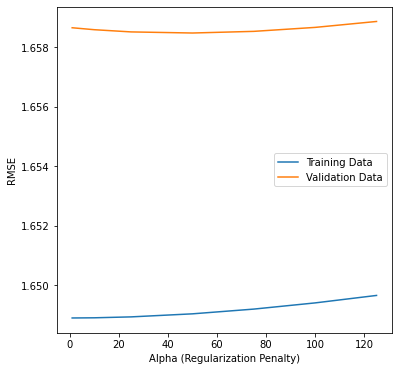

In [27]:
train_rmse = []
val_rmse = []

# Create list of alphas we want to consider
alphas = [1, 10, 25, 50, 75, 100, 125]#, 250, 500, 1000, 1500, 2000, 3000, 4000]

for alpha in alphas:
    # Fit a model with a given regularization penalty
    model = Ridge(random_state=42, alpha=alpha)
    model.fit(X_train_scaled, y_train)
    
    # RMSE for training data
    y_pred_ridge = model.predict(X_train_scaled)
    train_rmse.append(mean_squared_error(y_train, y_pred_ridge, squared=False))
    
    # RMSE for validation data
    ridge_cv = cross_val_score(model, X_train_scaled, y_train, scoring="neg_root_mean_squared_error")
    val_rmse.append(-(ridge_cv.mean()))

# Plot train vs. validation RMSE
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(alphas, train_rmse, label="Training Data")
ax.plot(alphas, val_rmse, label="Validation Data")
ax.set_xlabel("Alpha (Regularization Penalty)")
ax.set_ylabel("RMSE")
ax.legend();

In [28]:
lowest_rmse = min(val_rmse)
print("Lowest RMSE:", lowest_rmse)

best_alpha = alphas[val_rmse.index(lowest_rmse)]
print("Best alpha:", best_alpha)

Lowest RMSE: 1.6584822220789632
Best alpha: 50


So just by visualizing the Model above, **dramatically increasing our alphas only really changing the RMSE for our validation data ever so slightly**, about 0.001 RMSE. Which is definitely not statistically signifcant

In [30]:
final_model = Ridge(random_state=100, alpha=best_alpha)
final_model.fit(X_train_scaled, y_train)

# RMSE for training data
y_pred_final = final_model.predict(X_train_scaled)
final_rmse = mean_squared_error(y_train, y_pred_final, squared=False)

# RMSE for validation data
final_cv = cross_val_score(final_model, X_train_scaled, y_train, scoring="neg_root_mean_squared_error")
final_cv_rmse = -(final_cv.mean())

In [31]:
print("Baseline Model")
print("Train RMSE:", baseline_rmse)
print("Validation RMSE:", baseline_cv_rmse)
print()
print("Model with Polynomial Transformation (Degree 1)")
print("Train RMSE:", final_poly_rmse)
print("Validation RMSE:", final_poly_cv_rmse)
print()
print("Model with Polynomial Transformation + Regularization")
print("Train RMSE:", ridge_rmse)
print("Validation RMSE:", ridge_cv_rmse)

Baseline Model
Train RMSE: 1.6489071991810345
Validation RMSE: 1.658667284536147

Model with Polynomial Transformation (Degree 1)
Train RMSE: 1.6489071991810345
Validation RMSE: 1.6586672845361465

Model with Polynomial Transformation + Regularization
Train RMSE: 1.6489072606577444
Validation RMSE: 1.6586589681361872


So for our final model after all tuning, we didn't manage to move much from our original simple Linear Regression model. Which is ok because remember that was already performing reasonably. 

We'll explore some reasons for the seemingly irreducible error in our takeaways. And we'll discuss what could be done to further tune our model to get past some of those barriers.

First though, we'll take a closer look at this model's performance.

## Evaluate a Final Model on the Test Set

In [32]:
# Instantiate the final model
final_model = Ridge(alpha= best_alpha, random_state= 100)

#Fit the model
final_model.fit(X_train_scaled, y_train)

# Add polynomial features (these steps left in for easier replication and for future data that may make this useful)
X_test_poly = poly.transform(X_test)

# Scale data
X_test_scaled = scaler.transform(X_test_poly)

In [33]:
# Generate predictions
y_pred_test = final_model.predict(X_test_scaled)

# Find RMSE
test_rmse = mean_squared_error(y_test, y_pred_test, squared= False)
test_rmse

1.711034418590015

So our RMSE error on our test data is a little higher than what we saw in our validation set, but not by a significant margin.

Let's visualize our model's performance to see if we can identify where the model is making it's errors

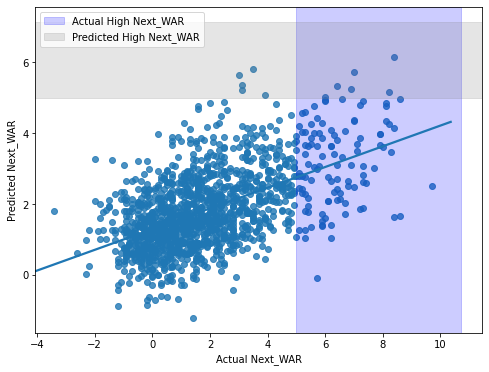

In [34]:
# Set up plot
fig, ax = plt.subplots(figsize=(8,6))

# Seaborn scatter plot with best fit line
sns.regplot(x=y_test, y=y_pred_test, ci=None, truncate=False, ax=ax)
ax.set_xlabel("Actual Next_WAR")
ax.set_ylabel("Predicted Next_WAR")

# Add spans showing high blood pressure + legend
ax.axvspan(5, max(y_test) + 1, alpha=0.2, color="blue", label="Actual High Next_WAR")
ax.axhspan(5, max(y_pred_test) + 1, alpha=0.2, color="gray", label="Predicted High Next_WAR")
ax.legend();

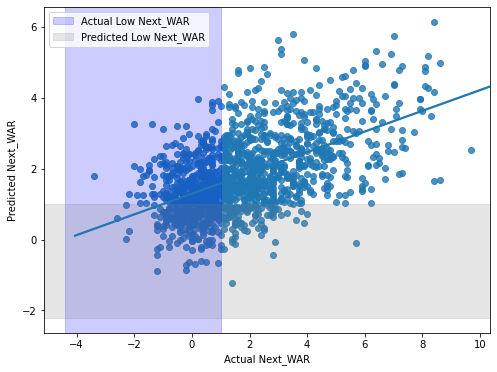

In [36]:
# Set up plot
fig, ax = plt.subplots(figsize=(8,6))

# Seaborn scatter plot with best fit line
sns.regplot(x=y_test, y=y_pred_test, ci=None, truncate=False, ax=ax)
ax.set_xlabel("Actual Next_WAR")
ax.set_ylabel("Predicted Next_WAR")

# Add spans showing high blood pressure + legend
ax.axvspan(min(y_test) + -1, 1, alpha=0.2, color="blue", label="Actual Low Next_WAR")
ax.axhspan(min(y_pred_test) - 1, 1, alpha=0.2, color="gray", label="Predicted Low Next_WAR")
ax.legend();

## Conclusion

Our model is **performing pretty well at prediction seasons where players are going to have mediocre to poor WARs**.

**Where the model is failing is in identifying when players are going to have exceptionally strong seasons**. This could make sense, players have "oddities" of seaasons from time to time, where through some combination of luck and streaky spurts of talent a player makes a name for themselves in the MLB.

In many cases a player doesn't come up to the MLB and make a splash their rookie year, and if they are great in their rookie year, they're still unproven, so they'll be hitting lower in the lineup  and getting less play opportunities. 

That said, the model was still able to predict within 1 standard deviation on average, which should definitely give some level of confidence.

That said, in terms of our business values **the model needs to be more consistent to provide industry value**. 

Whether you're a Team Manager, a front office General Manager, or setting the betting lines for a sport's betting company, **you want to feel like your model has an edge on what conclusions you could come up with with regular obesvations**. So while the model isn't completely failing, there are certainly additional steps that could stengthen it.

#### Next Steps

1. Since we've identified that our model does poorly at predicting breakout performances, a solution could be that the model needs to find a way to incorporate their **Minor League stats**.
2. Could we expand our model potentially to **track how a pattern of WAR over several seasons can predict Next_WAR**? Rather than predicting next season WAR off just the prior season's stats.
3. **Lets test our model with prediction based off the 2022 season and track it's successes and failures**


### Bonus: Predicting 2023 season WAR

In [40]:
def predict_2023_performance(pos):
    
    #Pull pos player's 2022 season statistics
    posbatstat = batting_stats(2022, 2022, qual=200, position = pos)
    
    #sort to only have the predictor variables
    pos_input = posbatstat[predictors]
    
    #poly transform the pos_input data
    pos_poly = poly.transform(pos_input)
    
    #This is an ugly way of extracting the Next_WAR data from the prediction as a pandas DataFrame
    pos_predictions = pd.DataFrame(final_model.predict(pos_poly))
    pos_predictions["Next_WAR"] = pos_predictions[0]
    
    #Pull predictions together with input frame
    pos_output = pos_input.join(pos_predictions)
    
    #Pull output together with Name Season and Team variables that were lost
    pos_output = pd.DataFrame(posbatstat[["Name", "Season", "Team"]]).join(pos_output)
    
    return pos_output

**Lets look at how the top our model predicts the top 10 shortstops from 2022 to perform in 2023**

In [46]:
sspred = predict_2023_performance("SS")
sspred[["Name", "Season", "Team", "WAR", "Next_WAR"]].head(10)

,Name,Season,Team,WAR,Next_WAR
4,Francisco Lindor,2022,NYM,6.8,6.917300
5,Dansby Swanson,2022,ATL,6.4,1.667297
2,Trea Turner,2022,LAD,6.3,5.832474
0,Xander Bogaerts,2022,BOS,6.1,1.604064
12,Tommy Edman,2022,STL,5.6,-2.443622
7,Willy Adames,2022,MIL,4.7,14.560846
3,Bo Bichette,2022,TOR,4.5,2.100935
6,Corey Seager,2022,TEX,4.5,8.921839
1,Carlos Correa,2022,MIN,4.4,3.902566
11,Nico Hoerner,2022,CHC,4.0,-0.616988


That's quite shocking that **Willy Adames has a Next_WAR predicted at 14.56**, which would would be the **single greatest season of any player ever**... and he recorded just the **6th best WAR from the 2022 season**.

It will certainly be entertaining to watch if that ends up being the case!